In [1]:
import pandas as pd
import os
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from nltk.corpus import stopwords


In [2]:
# df = pd.read_csv('AnnotatedDocuments - Cases.tsv', sep='\t')
df = pd.read_csv('AnnotatedDocumentsMyEdits.tsv', sep='\t')
df.set_index('Case Name',inplace=True)
df.head(2)

,Offence_final,Offence,Outcome: SM,Outcome: Overall Verdict,Support,Prior case Influence,Platform,Evidence Type,Unnamed: 9
Case Name,,,,,,,,,
People v Wells,murder,Murder in the second degree; criminal possessi...,"However, the admission of the photographs was ...",Judgement is affirmed,We agree with the Supreme Court's determinatio...,People v Price ; People v Patterson; People v ...,Facebook; Instagram,Photographs,NaN
Pecile v Titan Capital Group,sexual harassment,sexual harassment,Regarding defendants' demand for access to pla...,NaN,NaN,"Tapp v New York State Urban Dev. Corp.,",Social media,Posts,NaN


In [3]:
df.dropna(axis=0, how='all',inplace=True)
print("Num cases annotated: ",len(df))
df.isnull().sum()

Num cases annotated:  39


Offence_final                1
Offence                      1
Outcome: SM                  7
Outcome: Overall Verdict     3
Support                      7
Prior case Influence         4
Platform                     4
Evidence Type                5
Unnamed: 9                  37
dtype: int64

## Topic Modelling - All text

In [4]:
df['all_text']=df['Outcome: SM']+' '+df['Support']+' '+df['Outcome: Overall Verdict']
# what is SORA?
import gensim
docs_words = []
for text in df['all_text'].dropna():
    docs_words.append(gensim.utils.simple_preprocess(text, deacc=True))
ids = df['all_text'].dropna().index
len(docs_words)

30

In [5]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

stop_words = stopwords.words('english')
# stop_words.extend(['facebook','myspace','defendant','defendent','complainant','st','paul','post','posting','evidence','court','video','photo','photograph'])
stop_words.extend(['defendant','defendent','complainant'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(docs_words, min_count=5, threshold=100) # higher threshold fewer phrases. 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


# Remove Stop Words
docs_words_nostops = remove_stopwords(docs_words)

# Form Bigrams
data_words_bigrams = make_bigrams(docs_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(docs_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

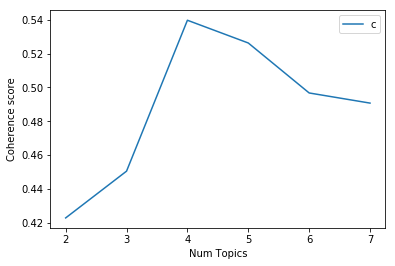

In [6]:
mallet_path = '/Users/rakshitanagalla/Desktop/SSW-Legal/mallet-2.0.8/bin/mallet'
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    For details, refer: 

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') # try 'u_mass' too
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=8, step=1)
# Show graph
# limit=12; start=2; step=2;
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [7]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4228
Num Topics = 3  has Coherence Value of 0.4504
Num Topics = 4  has Coherence Value of 0.5397
Num Topics = 5  has Coherence Value of 0.5263
Num Topics = 6  has Coherence Value of 0.4967
Num Topics = 7  has Coherence Value of 0.4907


In [10]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.058*"evidence" + 0.037*"witness" + 0.037*"motion" + 0.037*"photo" + '
  '0.026*"photograph" + 0.026*"deny" + 0.021*"include" + 0.018*"criminal" + '
  '0.018*"record" + 0.018*"possession"'),
 (1,
  '0.090*"facebook" + 0.037*"post" + 0.018*"page" + 0.018*"friend" + '
  '0.018*"order" + 0.018*"people" + 0.016*"staff" + 0.013*"conduct" + '
  '0.013*"student" + 0.013*"specific"'),
 (2,
  '0.051*"court" + 0.034*"video" + 0.032*"message" + 0.032*"evidence" + '
  '0.024*"testimony" + 0.024*"trial" + 0.024*"juror" + 0.022*"victim" + '
  '0.022*"make" + 0.020*"social"'),
 (3,
  '0.039*"myspace" + 0.039*"year" + 0.036*"sentence" + 0.031*"account" + '
  '0.025*"claim" + 0.022*"sex" + 0.017*"offender" + 0.017*"term" + '
  '0.017*"give" + 0.017*"count"')]


## Visualize Keywords

In [11]:
state_file = optimal_model.fstate()
print(state_file)
from process_pyldaviz import get_pyldaviz
lda_prop = get_pyldaviz(state_file)
vis_data = pyLDAvis.prepare(**lda_prop)
pyLDAvis.display(vis_data)

/var/folders/8g/1g347k696y56fdzqtj5x54cr0000gn/T/70e63c_state.mallet.gz
[12.5, 12.5, 12.5, 12.5], 0.01


//anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Dominant topic in each of the cases

In [12]:
data = [' '.join(doc) for doc in docs_words]

def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# df_dominant_topic.head(10)

In [13]:
df_dominant_topic['Case Name'] = list(df.dropna(subset=['all_text']).index)
df_dominant_topic.sort_values(by=['Topic_Perc_Contrib'], ascending=False)[['Case Name','Dominant_Topic','Topic_Perc_Contrib','Text','Keywords']].head(5)

,Case Name,Dominant_Topic,Topic_Perc_Contrib,Text,Keywords
6,"St. Paul's Sch. of Nursing, Inc. v. Papaspirid...",1.0,0.7496,since facebook serves to allow interaction thr...,"facebook, post, page, friend, order, people, s..."
3,People v Jackson,2.0,0.5507,based on the facts and circumstances of this c...,"court, video, message, evidence, testimony, tr..."
4,People v Santiago,0.0,0.4431,based upon evidence adduced at the hearing inc...,"evidence, witness, motion, photo, photograph, ..."
7,United States v. Farrad,0.0,0.4215,no physical evidence witness claims or defenda...,"evidence, witness, motion, photo, photograph, ..."
29,People v McEvoy,3.0,0.4148,his exhibits of the complaintant facebook prof...,"myspace, year, sentence, account, claim, sex, ..."


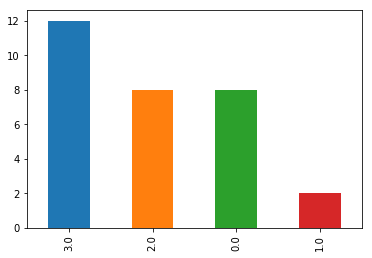

In [14]:
df_dominant_topic.Dominant_Topic.value_counts().plot(kind='bar')

(array([12.,  6.,  8.,  2.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([27.85 , 32.561, 37.272, 41.983, 46.694, 51.405, 56.116, 60.827,
        65.538, 70.249, 74.96 ]),
 <a list of 10 Patch objects>)

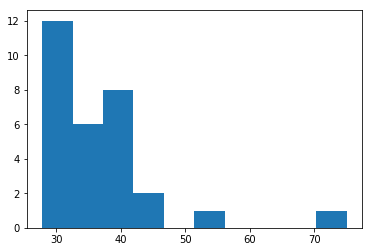

In [15]:
plt.hist(df_dominant_topic['Topic_Perc_Contrib']*100)

In [16]:
a=pd.merge(df_dominant_topic, df[['Platform','Evidence Type','Offence']].reset_index(), on = 'Case Name').groupby('Dominant_Topic')['Evidence Type'].unique()
a

Dominant_Topic
0.0            [Photographs, Friends, Messaging (inbox)]
1.0    [Various activities i.e., friend requests;post...
2.0    [Posts, Video, Messaging (inbox), Exploring th...
3.0    [Messaging , Posts, Messaging (inbox), Unspeci...
Name: Evidence Type, dtype: object

In [17]:
a[1]

array(['Various activities i.e., friend requests;posts',
       'Posts;video;photographs'], dtype=object)

## Most representative document for each topic

In [18]:
# Group top 5 sentences under each topic

df_topic_sents_keywords['Case Name'] = list(df.dropna(subset=['all_text']).index)

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text",'Case Name']

# Show
sent_topics_sorteddf_mallet[['Topic_Num',"Topic_Perc_Contrib",'Case Name',"Keywords", "Text"]]#.head()

,Topic_Num,Topic_Perc_Contrib,Case Name,Keywords,Text
0,0.0,0.4431,People v Santiago,"evidence, witness, motion, photo, photograph, ...",based upon evidence adduced at the hearing inc...
1,1.0,0.7496,"St. Paul's Sch. of Nursing, Inc. v. Papaspirid...","facebook, post, page, friend, order, people, s...",since facebook serves to allow interaction thr...
2,2.0,0.5507,People v Jackson,"court, video, message, evidence, testimony, tr...",based on the facts and circumstances of this c...
3,3.0,0.4148,People v McEvoy,"myspace, year, sentence, account, claim, sex, ...",his exhibits of the complaintant facebook prof...


## Topic distribution across documents

In [54]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"year, sentence, message, victim, sex, people, ...",8,0.2667
1,1.0,"video, juror, social, include, base, law, supp...",8,0.2667
2,2.0,"evidence, court, motion, witness, trial, photo...",5,0.1667
3,3.0,"photo, myspace, account, testimony, claim, tes...",7,0.2333
4,4.0,"facebook, post, make, order, page, friend, cou...",2,0.0667
